# Machine Learning for metabolomes of microbial communities

In [1]:
# imports
import sys
sys.path.append( '../FIA' )
sys.path.append( '../ML' )

from FIA import *
from ML4com import *

## Loading in

In [2]:
info_dir = "../../data/comm8_self"
data_dir = "../../runs/FIA/comm8/oms"
run_dir = "../../runs/ML/try"

info_dir = os.path.normpath(os.path.join(os.getcwd(), info_dir))
data_dir = os.path.normpath(os.path.join(os.getcwd(), data_dir))
run_dir = os.path.normpath(os.path.join(os.getcwd(), run_dir))

strains = pd.read_csv(os.path.join(info_dir, "strains.tsv"), sep="\t")
comm8 = pd.read_csv(os.path.join(info_dir, "comm8.tsv"), sep="\t")

fia_df = load_fia_df(data_dir, file_ending=".mzML", separator="\t")

Loading experiments:


100%|██████████| 68/68 [00:00<00:00, 100.30it/s]


Loading names:


100%|██████████| 72/72 [00:00<?, ?it/s]


## Binning

In [3]:
# binned_dfs = bin_df_stepwise_batch(fia_df, binning_var="mz", binned_var="inty", statistic="sum", start=50.0, stop=1700.0, step=0.002)
# binned_dfs.to_csv(os.path.join(run_dir, "data_matrix.tsv"), sep="\t")
binned_dfs = pd.read_csv(os.path.join(run_dir, "data_matrix.tsv"), sep="\t", index_col="mz", engine="pyarrow")

## Normalization

In [4]:
scaler = MaxAbsScaler()
binned_dfs[:] =  scaler.fit_transform(binned_dfs)

In [ ]:
break

## Learning and tuning

### Decision Tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0.01, 0.05, 0.1, 0.2]}
]

grids = grid_search_params_cv_model(DecisionTreeClassifier, param_grid, binned_dfs, comm8.values, strains.values, n_splits=5, n_jobs=1)

NameError: name 'search_params_cv_model' is not defined

In [ ]:
from sklearn.tree import DecisionTreeClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0.01, 0.05, 0.1, 0.2]}
]

results = train_cv_model(DecisionTreeClassifier, param_grid, binned_dfs, comm8, strains.values, os.path.join(run_dir, "decision_tree"), suffix="", n_fold=5)

NameError: name 'train_cv_model' is not defined

### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
param_grid = [
    {"random_state": [42],
     "ccp_alpha": [0, 0.5, 0.025],
     "n_estimators": [10, 100, 400],
     "max_depth": [None, 5, 20]}
]

results = train_cv_model(RandomForestClassifier, param_grid, binned_dfs, comm8, strains.values, os.path.join(run_dir, "random_forest"), suffix="", n_fold=5)

Parameter combinations 1:


 28%|██▊       | 15/54 [09:59<25:58, 39.97s/it]


KeyboardInterrupt: 

### SVM

In [ ]:
np.logspace(-9, 3, 13)

array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [ ]:
from sklearn.svm import SVC
param_grid = [
    {"random_state": [42],
     "kernel": ["linear"],
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

     {"random_state": [42],
     "kernel": ["polynomial"],
     "degree": [2, 3],
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

    {"random_state": [42],
     "kernel": ["sigmoid"],             # tanh
     "coef0" : np.logspace(-2, 3, 6),
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]},

    {"random_state": [42],
     "kernel": ["rbf",],
     "gamma": np.logspace(-4, 2, 7),
     "cache_size": [1000],
     "decision_function_shape": ["ovr"]}
]

results = train_cv_model(SVC, param_grid, binned_dfs, comm8, strains.values, os.path.join(run_dir, "svm"), suffix="", n_fold=5)

### Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier
param_grid = [
    {"random_state": [42],
     "activation": ["identity", "logistic", "relu"],
     "solver": ['adam'],
     "alpha": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1],
     "hidden_layer_sizes": [(500, 100), (100, 100), (20, 100), (100, 20), (500, 20)],
     "max_iter": [1000]},

    {"random_state": [42],
     'solver': ['rbf'],
     "activation": ["identity", "logistic", "relu"],
     'C': [1, 10, 100, 1000],
     'gamma': [0.001, 0.0001],
     "max_iter": [1000]},
]

results = train_cv_model(MLPClassifier, param_grid, binned_dfs, comm8, strains.values, os.path.join(run_dir, "multi_layer_perceptron"), suffix="", n_fold=5)

Parameter combination 0:


  0%|          | 0/90 [00:00<?, ?it/s]c:\Users\JosuaCarl\miniconda3\envs\gemml\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


## Analyis

In [ ]:
sns.lineplot(data=results, y="accuracy", x="ccp_alpha", hue="target")

NameError: name 'results' is not defined

<Axes: xlabel='ccp_alpha', ylabel='accuracy'>

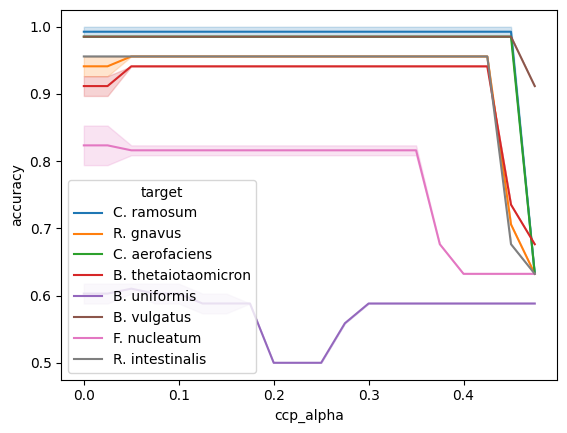

In [ ]:
sns.lineplot(data=results, y="accuracy", x="ccp_alpha", hue="target")

## In-depth analysis

In [ ]:
model = DecisionTreeClassifier(random_state=42)

# for i, estimator in enumerate(model.estimators_):
for i, s in enumerate(strains):
    model.fit(X.transpose(),ys.transpose()[i])
    plot_decision_trees(model=model, feature_names=X.index, class_names=["absent", s], outdir=outdir, name=f"decisiontree/tree_{s}{suffix}")